# Classifying MNIST with Quanvolutional Neural Networks

Adapted from the tutorial at https://pennylane.ai/qml/demos/tutorial_quanvolution/

In [ ]:
!pip install matplotlib pennylane tensorflow tf-keras

In [1]:
import matplotlib.pyplot as plt
import pennylane as qml
import tensorflow as tf
from pennylane import numpy as np
from tensorflow import keras

In [ ]:
np.random.seed(0)
tf.random.set_seed(0)

In [2]:
n_train = 500
n_test = 300

epochs = 20
batch_size = 32

Load and preprocess MNIST dataset as we normally do

In [3]:
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

In [4]:
train_images.shape

(60000, 28, 28)

In [5]:
test_images.shape

(10000, 28, 28)

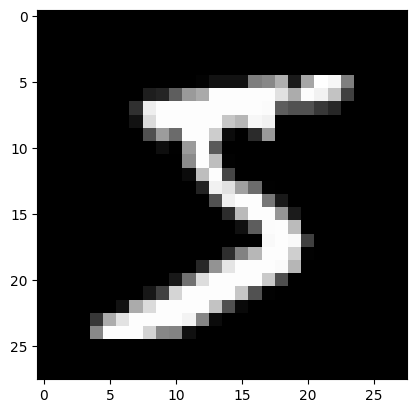

In [6]:
pixels = train_images[0].reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.show()

In [7]:
train_labels[0]

5

In [8]:
# Reduce dataset size so we can run the quantum part
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

### Classical benchmark

The CNN in the tutorial was very simple, here we use a more sophisticated network that is closer to what we would use in practice while keeping the convolution scheme similar.

In [9]:
def classical_model():
  model = keras.models.Sequential()
  model.add(keras.layers.Input(shape=(28, 28, 1)))
  model.add(keras.layers.Conv2D(4, (3, 3), activation="relu", kernel_initializer="he_uniform"))
  model.add(keras.layers.MaxPooling2D((2, 2)))
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(100, activation="relu", kernel_initializer="he_uniform"))
  model.add(keras.layers.Dense(10, activation="softmax"))
  opt = keras.optimizers.Adam(learning_rate=0.001)
  model.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
  return model

In [10]:
model = classical_model()
history = model.fit(train_images, train_labels, epochs=epochs, batch_size=batch_size, validation_data=(test_images, test_labels), verbose=2)

Epoch 1/20
16/16 - 1s - 85ms/step - accuracy: 0.4620 - loss: 1.8557 - val_accuracy: 0.5967 - val_loss: 1.5306
Epoch 2/20
16/16 - 0s - 9ms/step - accuracy: 0.8000 - loss: 0.9539 - val_accuracy: 0.7267 - val_loss: 0.9731
Epoch 3/20
16/16 - 0s - 11ms/step - accuracy: 0.8520 - loss: 0.5796 - val_accuracy: 0.7600 - val_loss: 0.7491
Epoch 4/20
16/16 - 0s - 9ms/step - accuracy: 0.8940 - loss: 0.4019 - val_accuracy: 0.8133 - val_loss: 0.6156
Epoch 5/20
16/16 - 0s - 9ms/step - accuracy: 0.9100 - loss: 0.3140 - val_accuracy: 0.8400 - val_loss: 0.5440
Epoch 6/20
16/16 - 0s - 9ms/step - accuracy: 0.9380 - loss: 0.2596 - val_accuracy: 0.8767 - val_loss: 0.4595
Epoch 7/20
16/16 - 0s - 8ms/step - accuracy: 0.9560 - loss: 0.1996 - val_accuracy: 0.8833 - val_loss: 0.4417
Epoch 8/20
16/16 - 0s - 9ms/step - accuracy: 0.9560 - loss: 0.1587 - val_accuracy: 0.8767 - val_loss: 0.4116
Epoch 9/20
16/16 - 0s - 11ms/step - accuracy: 0.9800 - loss: 0.1293 - val_accuracy: 0.8867 - val_loss: 0.3777
Epoch 10/20
16/1

### Hybrid quantum-classical model

In [11]:
n_quantum_layers = 1
n_qubits = 4

scale = np.pi

In [12]:
dev = qml.device("default.qubit", wires=n_qubits)

Quantum circuit as a convolutional kernel

In [13]:
rand_params = np.random.uniform(high=2*scale, size=(n_quantum_layers, n_qubits))

@qml.qnode(dev)
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(n_qubits):
        qml.RY(np.pi * phi[j], wires=j)
    # Random quantum circuit
    qml.templates.RandomLayers(rand_params, wires=list(range(n_qubits)))
    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(n_qubits)]

Convolution scheme - in a standard CNN, this would correspond to a convolution with a 2 x 2 kernel and a stride equal to 2

In [14]:
def quanv(image):
    out = np.zeros((14, 14, 4))
    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit([
                image[j, k, 0],
                image[j, k + 1, 0],
                image[j + 1, k, 0],
                image[j + 1, k + 1, 0]
            ])
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(n_qubits):
                out[j // 2, k // 2, c] = q_results[c]
    return out

If we aren't going to train the quantum layer, we only need to do the convolutions once

In [ ]:
print("Quantum pre-processing of train images:")
q_train_images = []
for idx, img in enumerate(train_images):
  print("{}/{}        ".format(idx + 1, n_train), end="\r")
  q_train_images.append(quanv(img))
q_train_images = np.asarray(q_train_images)

np.save("q_train_images.npy", q_train_images)

print("\nQuantum pre-processing of test images:")
q_test_images = []
for idx, img in enumerate(test_images):
  print("{}/{}        ".format(idx + 1, n_test), end="\r")
  q_test_images.append(quanv(img))
q_test_images = np.asarray(q_test_images)

np.save("q_test_images.npy", q_test_images)

In [15]:
q_train_images = np.load("q_train_images.npy")
q_test_images = np.load("q_test_images.npy")

What did this do? The shapes of the numbers are preserved albeit somewhat distorted, and the resolution is downsampled. This is what we would expect from the convolution and max pooling layers of a classical CNN.

Why are we doing this? A quantum circuit can generate highly complex kernels whose computation could be classically intractable.

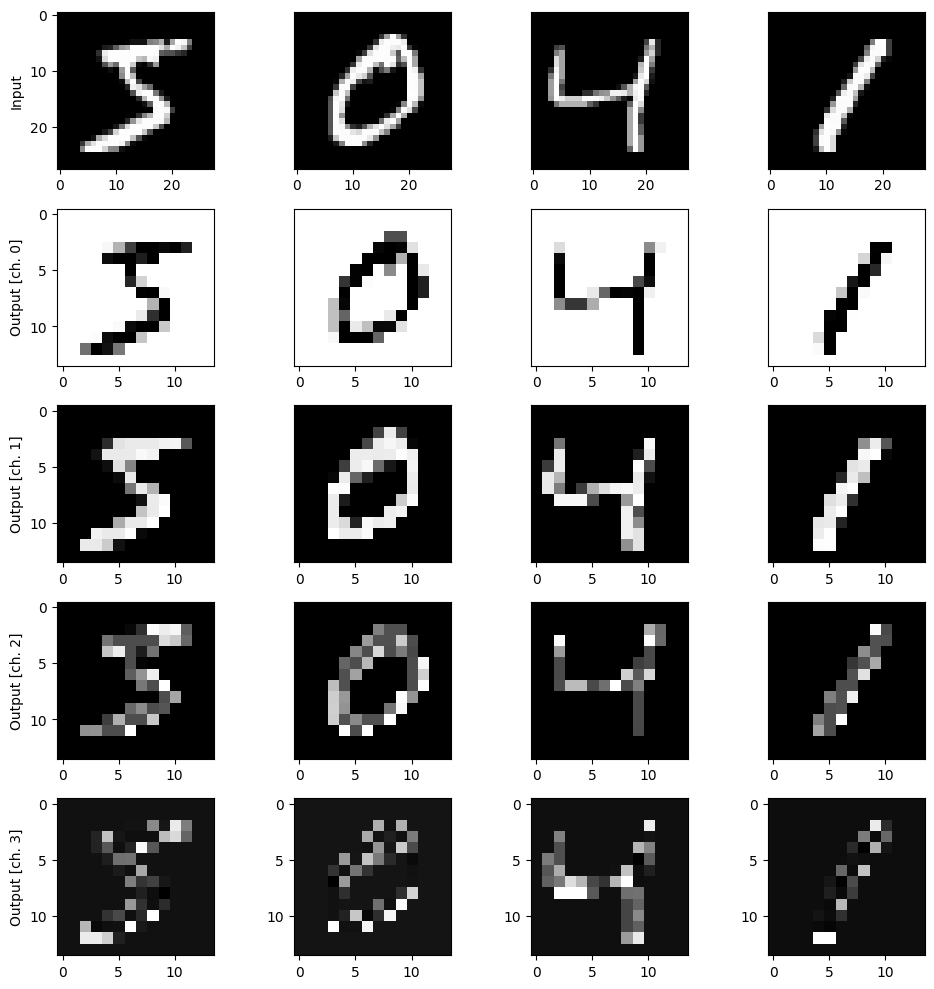

In [17]:
n_samples = 4
n_channels = 4

fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))

for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

Now we again train a classical model but we replace the convolution layer with our pre-computed quantum convolution

In [18]:
def quantum_model():
  model = keras.models.Sequential()
  model.add(keras.layers.Input(shape=(14, 14, 4)))
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(100, activation="relu", kernel_initializer="he_uniform"))
  model.add(keras.layers.Dense(10, activation="softmax"))
  opt = keras.optimizers.Adam(learning_rate=0.001)
  model.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
  return model

In [19]:
model = quantum_model()
q_history = model.fit(q_train_images, train_labels, epochs=epochs, batch_size=batch_size, validation_data=(q_test_images, test_labels), verbose=2)

Epoch 1/20
16/16 - 1s - 75ms/step - accuracy: 0.3780 - loss: 1.9024 - val_accuracy: 0.4967 - val_loss: 1.5091
Epoch 2/20
16/16 - 0s - 7ms/step - accuracy: 0.7700 - loss: 0.9715 - val_accuracy: 0.6733 - val_loss: 1.0869
Epoch 3/20
16/16 - 0s - 8ms/step - accuracy: 0.8400 - loss: 0.6452 - val_accuracy: 0.6967 - val_loss: 0.9105
Epoch 4/20
16/16 - 0s - 7ms/step - accuracy: 0.8740 - loss: 0.4892 - val_accuracy: 0.7867 - val_loss: 0.7102
Epoch 5/20
16/16 - 0s - 7ms/step - accuracy: 0.9060 - loss: 0.3831 - val_accuracy: 0.7400 - val_loss: 0.7310
Epoch 6/20
16/16 - 0s - 8ms/step - accuracy: 0.9260 - loss: 0.3238 - val_accuracy: 0.7300 - val_loss: 0.7281
Epoch 7/20
16/16 - 0s - 8ms/step - accuracy: 0.9400 - loss: 0.2623 - val_accuracy: 0.7900 - val_loss: 0.5820
Epoch 8/20
16/16 - 0s - 8ms/step - accuracy: 0.9520 - loss: 0.2192 - val_accuracy: 0.8033 - val_loss: 0.5612
Epoch 9/20
16/16 - 0s - 8ms/step - accuracy: 0.9600 - loss: 0.2030 - val_accuracy: 0.8200 - val_loss: 0.5286
Epoch 10/20
16/16 

### Compare classical and quantum results

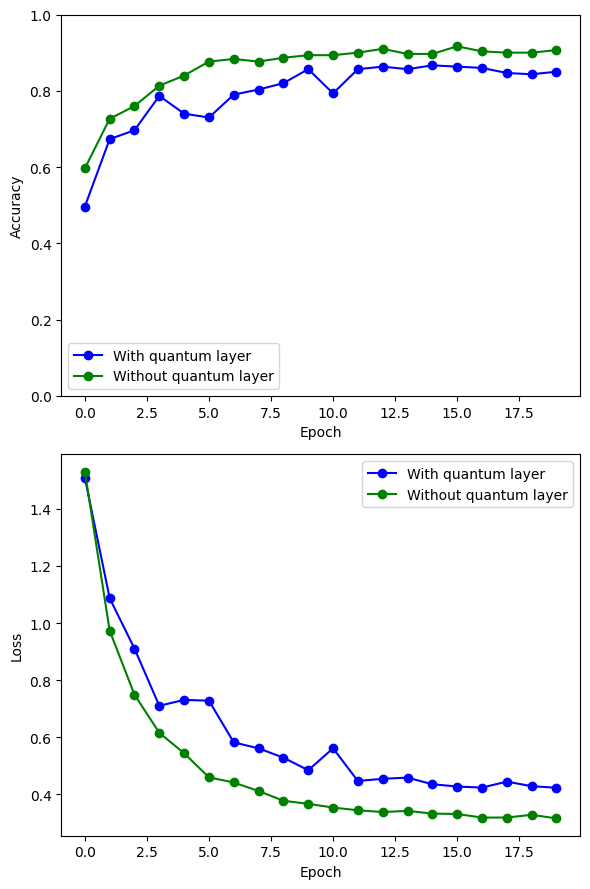

In [20]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

In this case the quantum convolution was not better than our original classical CNN. At 20 epochs of training, accuracy remains ~5% lower and loss remains ~0.1 higher with the quantum convolutions. This is not surprising since we are not training the quantum layer. And even though we attempted a fair comparison, the quantum convolutions implemented here are not necessarily as robust as the Conv2D/MaxPooling2D layer combo from Keras in the classical network.